# **IS4226 Systematic Trading Strategies and Systems**
## AY23/24 Semester 1 Final-Term Project

### <b> BB and MACD Strategy </b>
Submitted by <b> Group 2 </b> <br>
Brian Wong Chong Jun  |  A0214272N <br>
Chelsea Yap Yixian  |  A0239456U <br>
Foo Shi Hong  |  A0222889N <br>
Goh Hong Pei  |  A0216076H <br>
Sng Hong Wee Malcolm  |  A0217931E
<br>

This project aims to analyse how a trading strategy combining mean reversion and trend-following techniques, through the use of Bollinger Bands (BB) and Moving Average Convergence/Divergence (MACD) indicators, perform for a portfolio consisting of equally-weighted MAANG stocks.

Contents:
1. Functional Codes
2. Stock Selection
3. Randomised Backtest
4. Cache
5. Variations Analysis
6. Suitable Parameter Ranges
7. Final Model

<br>

For ease of navigation of this notebook, we recommend opening the outline/table of contents.

### <b>Functional Codes</b>

Prior to the analysis, we need to install and import the required libraries.

In [ ]:
# Install essential libraries
!pip install yfinance
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=fc58c51298e33d6f9c8bc7bb0610b945aba05959eea58e5f8f507d693b5d3bef
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [ ]:
# import essential libraries
import math
import pandas as pd
import numpy as np
import itertools
import operator
import random
from scipy import stats

from datetime import datetime as dt
from datetime import timedelta

import yfinance as yf

from ta.utils import dropna
from ta.trend import MACD
from ta.volatility import BollingerBands

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import warnings

# filter out RuntimeWarnings related to invalid value encountered in double_scalars
warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in double_scalars")

In [ ]:
# common class for common purposes including data preparation, order placing and result computation
class Common_Class():

  def __init__(self, symbol, benchmark, start, end, interval, capital, transcation_cost, verbose = True):

    # new dictionaries
    self.all_data = {} # closing price, stock daily returns and indicator values for each stock, at each bar
    self.position = {} # the trades in progress, long or short for stock
    self.quantity = {} # quantities to buy/sell for stock
    for stock in symbol:
      self.quantity[stock] = 0

    self.symbol = symbol
    self.benchmark = benchmark
    self.start = start
    self.end = end
    self.interval = interval
    self.initial_capital = capital # this is the initial capital you want to trade with
    self.capital = capital # this capital will change depending on trades
    self.transaction_cost = transcation_cost # the transaction cost for trading
    self.trades = 0 # Number of trades
    self.verbose = verbose # if you want to see detailed output (logs)
    self.stored_data = pd.DataFrame(columns = ['trade', 'date', 'position', 'price', 'symbol', 'quantity', 'capital']) # data of trade transactions

    self.prepare_data() # prepare the data


  # retrieve closing price and daily stock returns
  def prepare_data(self):

    all_stocks = list(self.symbol)
    all_stocks.append(self.benchmark)
    for stock in all_stocks:
      stock_data = yf.Ticker(stock)
      hist_stock = stock_data.history(start = (dt.strptime(self.start, "%Y-%m-%d") + timedelta(days=-38)).strftime('%Y-%m-%d'), end = (dt.strptime(self.end, "%Y-%m-%d") + timedelta(days=1)).strftime('%Y-%m-%d'), interval = self.interval)

      bt_data = pd.DataFrame()
      bt_data["Close_Price"] = hist_stock["Close"]
      bt_data["Return"] = np.log(bt_data["Close_Price"] / bt_data["Close_Price"].shift(1))
      bt_data = bt_data.dropna()
      self.all_data[stock] = bt_data


  # plot closing price of a given stock
  def close_graph(self, stock):

    plt.figure(figsize=(15, 5))
    plt.plot(self.all_data[stock]["Close_Price"] ,color='black', label='Price', linestyle='dashed')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.title("Close Prices of {}".format(stock))
    plt.legend()
    plt.grid()
    plt.show()


  # retrieve date and price for a given stock at a given bar
  def return_date_price(self, bar, stock):

    date = str(self.all_data[stock].index[bar])[:10] # retrieve date elements from date-time
    price = self.all_data[stock].Close_Price.iloc[bar]
    return date, price


  # retrieve realised capital in your account at a given time period / bar
  def realised_balance(self, bar):

    date, price = self.return_date_price(bar, self.symbol[0])
    # print("Date :{} | Realised Balance: {:0.1f}".format(date, self.capital))


  # retrieve unrealised capital (trades in progress) in your account at a given time period / bar
  def unrealised_balance(self, bar):

    ub = 0
    for stock in self.symbol:
      date, price = self.return_date_price(bar, stock)
      ub = ub + self.quantity[stock] * price
    # print("Date :{} | Unrealised Balance: {:0.1f}".format(date, ub))


  # retrieve total balance (unrealised balance + realised balance)
  def total_balance(self, bar):

    ub = 0
    for stock in self.symbol:
      date, price = self.return_date_price(bar, stock)
      ub = ub + self.quantity[stock] * price
    tb = ub + self.capital
    # print("Date :{} | Total Balance: {:0.1f}".format(date,tb))
    return tb


  # store the trade details in dataframe
  def store_results(self, trade, date, position, price, symbol, quantity, capital):

    trade_detail = pd.DataFrame({'trade': pd.Series(trade),
                                 'date': pd.Series(date),
                                 'position': pd.Series(position),
                                 'price': pd.Series(price),
                                 'symbol': pd.Series(symbol),
                                 'quantity': pd.Series(quantity),
                                 'capital': pd.Series(capital)
                                 })
    self.stored_data = pd.concat([self.stored_data, trade_detail])


  # plot key performance charts
  def performance_plots(self):

    final_result_data = self.final_result_data

    ## plot 1: cumulative log returns of stocks
    fig = px.line(title='<b>Cumulative Log Returns of Included Stocks</b>')
    for stock in self.symbol:
      fig.add_trace(
          go.Scatter(y=final_result_data['Returns_{}'.format(stock)].cumsum(), x=final_result_data['Returns_{}'.format(stock)].index, name='{}'.format(stock))
      )
    fig.add_trace(
        go.Scatter(y=self.all_data[self.benchmark]["Return"].cumsum(), x=self.all_data[self.benchmark]["Return"].index, name='{} (Benchmark)'.format(benchmark), line=dict(dash='dot'), line_color="grey")
    )
    fig.update_layout(height=500,
                    hovermode= 'x unified',
                    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01, bgcolor='rgba(255,255,255,0.6)')
                    )
    fig.update_xaxes(range=[final_result_data['Returns_{}'.format(stock)].index[0], final_result_data['Returns_{}'.format(stock)].index[-1]])
    fig.show()

    #plot 2: histogram of strategy returns
    fig = px.line(title='<b>Histogram of Strategy Returns</b>')
    fig.add_trace(
        go.Histogram(x=final_result_data['capital_log_returns'], name='Strategy Returns', marker = go.Marker(color='royalblue'))
    )
    fig.update_layout(height=500,
                    hovermode= 'x unified',
                    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01, bgcolor='rgba(255,255,255,0.6)')
                    )
    fig.show()
    #color_discrete_sequence=['royalblue']

    #plot 3: strategy cumulative returns
    fig = px.line(title='<b>Strategy Cumulative Return Curves</b>')
    fig.add_trace(
        go.Scatter(y=final_result_data['capital_returns_log_cum_sum'], x=final_result_data['capital_returns_log_cum_sum'].dropna().index, name='Strategy Returns', line_color='royalblue')
    )
    fig.add_trace(
        go.Scatter(y=final_result_data['total_stock_returns_cum_sum'], x=final_result_data['total_stock_returns_cum_sum'].index, name='Equally-Weighted Stock Returns', line_color='firebrick')
    )
    fig.add_trace(
        go.Scatter(y=self.all_data[self.benchmark]["Return"][final_result_data['total_stock_returns_cum_sum'].index].cumsum(), x=final_result_data['total_stock_returns_cum_sum'].index, name='Benchmark Returns', line_color='forestgreen')
    )
    fig.update_layout(height=500,
                    hovermode= 'x unified',
                    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01, bgcolor='rgba(255,255,255,0.6)')
                    )
    fig.update_xaxes(range=[final_result_data['capital_log_returns'].index[0], final_result_data['capital_log_returns'].index[-1]])
    fig.show()

    #plot 4: drawdown
    df = pd.DataFrame()
    df['capital'] = self.stored_data.groupby('date').agg({'capital':'mean'})

    trade_start_date = df['capital'].index[0]
    trade_end_date = df['capital'].index[-1]

    for stock in self.symbol:
      A = (self.all_data[stock][trade_start_date:trade_end_date]['Return'].tolist())
      df['Returns_{}'.format(stock)] = A
    c = df.columns
    df['total_stock_returns'] = (df.loc[:,c[-len(self.symbol):]].sum(1))/len(self.symbol)
    df['total_stock_returns_cum_sum'] = df['total_stock_returns'].cumsum()
    #df.index = range(df.shape[0])

    df['capital_after_settlement'] = df['capital'].shift(-1)

    df['capital_regular_returns'] = (df['capital_after_settlement']/df['capital']-1)
    df['capital_log_returns'] = np.log(df['capital_after_settlement']/df['capital'])
    df['capital_returns_log_cum_sum'] = df['capital_log_returns'].cumsum()

    df['cum_max'] = df['capital_returns_log_cum_sum'].cummax()
    df['drawdown'] = df["cum_max"] - df['capital_returns_log_cum_sum']

    df.drop(df.index[df['capital_log_returns'] == 0.0], inplace=True)
    df = df.dropna()

    drawdown_values = final_result_data['drawdown']
    zero_periods = list(drawdown_values[drawdown_values == 0].index)
    last_zero_drawdown_date = []
    current_zero_date = zero_periods[0]

    max_drawdown_value = drawdown_values.max()
    max_drawdown_date = drawdown_values.idxmax()

    ### For each date, obtain the last drawdown date
    for i in drawdown_values.index:
      ### If current date is a 0 drawdown date
      if zero_periods != [] and i == zero_periods[0]:
        ### Set new recent drawdown date
        current_zero_date = zero_periods.pop(0)
      ### Store the last drawdown date for this date
      last_zero_drawdown_date.append(current_zero_date)

    ### Calculate the drawdown duration based on last drawdown date
    drawdown_duration = np.array([dt.strptime(x, "%Y-%m-%d") for x in drawdown_values.index]) - np.array([dt.strptime(x, "%Y-%m-%d") for x in last_zero_drawdown_date])
    max_drawdown_duration = drawdown_duration.max()
    from_drawdown_date = last_zero_drawdown_date[np.where(drawdown_duration == max_drawdown_duration)[0][0]]
    to_drawdown_date = drawdown_values.index[np.where(drawdown_duration == max_drawdown_duration)[0][0]]


    ## Plot cumulative returns and maximum cumulative returns to visualize drawdown
    fig = px.line(title=f"<b>Drawdown</b>")
    fig.add_scatter(y=final_result_data['capital_returns_log_cum_sum'].dropna(), x=final_result_data['capital_returns_log_cum_sum'].dropna().index, name="Cumulative Log Returns", line_color="royalblue")
    fig.add_scatter(y=final_result_data['cum_max'].dropna(), x=final_result_data['cum_max'].dropna().index, name="Cumulative Maximum", line_color="crimson")

    ## Plot maximum drawdown
    fig.add_scatter(y=[final_result_data['capital_returns_log_cum_sum'].dropna()[max_drawdown_date],final_result_data['cum_max'].dropna()[max_drawdown_date]], x=[max_drawdown_date, max_drawdown_date], name="Maximum Drawdown", mode = "markers+lines", marker = dict(color = 'darkorange'), line=dict(dash='dot'), hoverinfo='skip')
    fig.add_annotation(x=max_drawdown_date, y=final_result_data['cum_max'].dropna()[max_drawdown_date], text=f"Max Drawdown = {str(round(max_drawdown_value,2))} (on {str(max_drawdown_date)[:10]})", showarrow=False, yshift=10, font={'color':'darkorange'}, bgcolor='rgba(255,255,255,0.5)')

    ## Plot longest drawdown duration
    fig.add_scatter(y=[final_result_data['capital_returns_log_cum_sum'].dropna()[from_drawdown_date:to_drawdown_date].min(),final_result_data['capital_returns_log_cum_sum'].dropna()[from_drawdown_date:to_drawdown_date].min()], x=[from_drawdown_date,to_drawdown_date], name="Maximum Drawdown Duration", mode = "markers+lines", marker = dict(color = 'purple'), line=dict(dash='dot'),  hoverinfo='skip')
    fig.add_annotation(x=(dt.strptime(from_drawdown_date, "%Y-%m-%d") + timedelta(days=(dt.strptime(to_drawdown_date, "%Y-%m-%d") - dt.strptime(from_drawdown_date, "%Y-%m-%d")).days//2)).strftime('%Y-%m-%d'), y=final_result_data['capital_returns_log_cum_sum'].dropna()[from_drawdown_date:to_drawdown_date].min(), text=f"Max Drawdown Duration = {str(max_drawdown_duration.days)} days (from {str(from_drawdown_date)[:10]} to {str(to_drawdown_date)[:10]})", showarrow=False, align='left', yshift=-10, font={'color':'purple'}, bgcolor='rgba(255,255,255,0.5)')

    fig.update_layout(height=500,
                    hovermode= 'x unified',
                    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01, bgcolor='rgba(255,255,255,0.6)')
                    )
    fig.update_xaxes(range=[final_result_data['capital_log_returns'].index[0], final_result_data['capital_log_returns'].index[-1]])
    fig.show()


    #plot 5: equity curve
    fig = px.line(title='<b>Equity Curve</b>')
    fig.add_trace(
        go.Scatter(y=final_result_data['capital'].dropna(), x=final_result_data['capital'].dropna().index, name='Equity $', line_color='royalblue')
    )
    fig.update_layout(height=500,
                    hovermode= 'x unified',
                    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01, bgcolor='rgba(255,255,255,0.6)')
                    )
    fig.show()


    #plot 6: new positions
    for stock in self.symbol:
      positions_df = self.stored_data[self.stored_data['symbol']==stock]
      positions_df['signal'] = positions_df['position'].diff()

      fig = px.line(title=f'<b>{stock} Price and New Positions Taken</b>')
      fig.add_trace(
          go.Scatter(y=self.all_data[stock]["Close_Price"], x=self.all_data[stock]["Close_Price"].index, name='Close Price', line_color='royalblue')
      )

      ## Plot long position signals
      fig.add_trace(
          go.Scatter(y=positions_df[(positions_df['position']==1) & (positions_df['signal']!=0)]['price'],
                    x=positions_df[(positions_df['position']==1) & (positions_df['signal']!=0)]['date'],
                    name="New Long Position",
                    mode='markers',
                    marker={'symbol':'triangle-up-dot', 'size':15, 'opacity':0.8},
                    line_color='green')
      )

      ## Plot short position signals
      fig.add_trace(
          go.Scatter(y=positions_df[(positions_df['position']==-1) & (positions_df['signal']!=0)]['price'],
                    x=positions_df[(positions_df['position']==-1) & (positions_df['signal']!=0)]['date'],
                    name="New Short Position",
                    mode='markers',
                    marker={'symbol':'triangle-down-dot', 'size':15, 'opacity':0.8},
                    line_color='red')
      )

      fig.update_layout(height=500,
                      hovermode= 'x unified',
                      legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01, bgcolor='rgba(255,255,255,0.6)')
                      )
      fig.update_xaxes(range=[final_result_data['capital_log_returns'].index[0], final_result_data['capital_log_returns'].index[-1]])
      fig.show()



  # compute performance of strategy
  def performance(self):

    df = pd.DataFrame()
    df['capital'] = self.stored_data.groupby('date').agg({'capital':'mean'})

    trade_start_date = df['capital'].index[0]
    trade_end_date = df['capital'].index[-1]

    for stock in self.symbol:
      A = (self.all_data[stock][trade_start_date:trade_end_date]['Return'].tolist())
      df['Returns_{}'.format(stock)] = A
    c = df.columns
    df['total_stock_returns'] = (df.loc[:,c[-len(self.symbol):]].sum(1))/len(self.symbol)
    df['total_stock_returns_cum_sum'] = df['total_stock_returns'].cumsum()
    #df.index = range(df.shape[0])

    df['capital_after_settlement'] = df['capital'].shift(-1)

    df['capital_regular_returns'] = (df['capital_after_settlement']/df['capital']-1)
    df['capital_log_returns'] = np.log(df['capital_after_settlement']/df['capital'])
    df['capital_returns_log_cum_sum'] = df['capital_log_returns'].cumsum()

    df['cum_max'] = df['capital_returns_log_cum_sum'].cummax()
    df['drawdown'] = df["cum_max"] - df['capital_returns_log_cum_sum']

    df.drop(df.index[df['capital_log_returns'] == 0.0], inplace=True)
    df = df.dropna()
    #df.index = self.stored_data.groupby('date').agg({'capital':'mean'}).index

    final_result_data = df

    print(" ")
    print("Performance Metrics")
    print("-" * 50)

    # Strategy Performance
    print("<<< Strategy Performance >>>")

    # total Balance
    print("The total capital at the end of strategy: ${:0.2f}".format(self.capital))

    # annual gross expected returns
    daily_log_mean_ret = final_result_data['capital_log_returns'].mean()
    annual_log_ret = 252 * daily_log_mean_ret
    annual_regular_return = (np.exp(annual_log_ret) -1)*100
    print("The annual regular returns: {:0.2f} %".format(annual_regular_return))

    # annual standard deviation
    daily_regular_std = (np.exp(final_result_data['capital_log_returns'])-1).std()
    annual_regular_std = daily_regular_std * (252**0.5) * 100
    print("The annual regular standard deviation: {:0.2f} %".format(annual_regular_std))

    # annual sharpe ratio
    SR = annual_regular_return / annual_regular_std
    print("The annual sharpe ratio: {:0.2f}".format(SR))

    returns = (self.capital - self.initial_capital) / self.initial_capital * 100
    print("The returns of investment from {} to {} by this strategy is {:0.2f} %".format(self.start, self.end, returns))

    # drawdown
    drawdown = final_result_data['drawdown'].max()*100
    max_drawdown = drawdown.max()
    print("The maximum drawdown: {:.2f} %".format(max_drawdown))

    # drawdown duration
    ## Find dates with zero drawdowns
    drawdown_values = final_result_data['drawdown']
    zero_periods = list(drawdown_values[drawdown_values == 0].index)
    last_zero_drawdown_date = []
    current_zero_date = zero_periods[0]

    ## For each date, obtain the last drawdown date
    for i in drawdown_values.index:
      ## If current date is a 0 drawdown date
      if zero_periods != [] and i == zero_periods[0]:
        ## Set new recent drawdown date
        current_zero_date = zero_periods.pop(0)
      ## Store the last drawdown date for this date
      last_zero_drawdown_date.append(current_zero_date)

    ## Calculate the drawdown duration based on last drawdown date
    drawdown_duration = np.array([dt.strptime(x, "%Y-%m-%d") for x in drawdown_values.index]) - np.array([dt.strptime(x, "%Y-%m-%d") for x in last_zero_drawdown_date])
    max_drawdown_duration = drawdown_duration.max()
    print("The maximum drawdown duration: {} days".format(max_drawdown_duration.days))

    # annual sortino ratio
    only_neg_log_returns = final_result_data[final_result_data['capital_log_returns']<0]['capital_log_returns']
    only_neg_regular_returns = np.exp(only_neg_log_returns)

    daily_std_dev_for_sortino = only_neg_regular_returns.std()
    annual_std_dev_for_sortino = daily_std_dev_for_sortino * (252 ** 0.5)*100

    sortino = annual_regular_return / annual_std_dev_for_sortino
    print("The annual sortino ratio: {:0.2f}".format(sortino))

    # annual calmar ratio
    calmar_ratio = annual_regular_return / max_drawdown
    print("The annual calmar ratio: {:0.2f}".format(calmar_ratio))

    # total trades
    print("The total trades taken by the strategy {}".format(self.trades))

    print("-" * 50)
    self.final_result_data = final_result_data

    # Equal-Weighted Stock Performance
    print("<<< Equal-Weighted Stock Performance >>>")

    df['stock_cum_max'] = df['total_stock_returns_cum_sum'].cummax()
    df['stock_drawdown'] = df["stock_cum_max"] - df['total_stock_returns_cum_sum']

    df.drop(df.index[df['total_stock_returns'] == 0.0], inplace=True)
    df = df.dropna()

    # annual gross expected returns
    daily_log_mean_ret = final_result_data['total_stock_returns'].mean()
    annual_log_ret = 252 * daily_log_mean_ret
    annual_regular_return = (np.exp(annual_log_ret) -1)*100
    print("The annual regular returns: {:0.2f} %".format(annual_regular_return))

    # annual standard deviation
    daily_regular_std = (np.exp(final_result_data['total_stock_returns'])-1).std()
    annual_regular_std = daily_regular_std * (252**0.5) * 100
    print("The annual regular standard deviation: {:0.2f} %".format(annual_regular_std))

    # annual sharpe ratio
    SR = annual_regular_return / annual_regular_std
    print("The annual sharpe ratio: {:0.2f}".format(SR))

    # returns = (self.capital - self.initial_capital) / self.initial_capital * 100
    returns = (np.exp(df['total_stock_returns'].sum())-1)*100
    print("The returns of investment from {} to {} by an equally-weighted stock strategy is {:0.2f} %".format(self.start, self.end, returns))

    # drawdown
    drawdown = final_result_data['stock_drawdown'].max()*100
    max_drawdown = drawdown.max()
    print("The maximum drawdown: {:.2f} %".format(max_drawdown))

    # drawdown duration
    ## Find dates with zero drawdowns
    drawdown_values = final_result_data['stock_drawdown']
    zero_periods = list(drawdown_values[drawdown_values == 0].index)
    last_zero_drawdown_date = []
    current_zero_date = zero_periods[0]

    ## For each date, obtain the last drawdown date
    for i in drawdown_values.index:
      ## If current date is a 0 drawdown date
      if zero_periods != [] and i == zero_periods[0]:
        ## Set new recent drawdown date
        current_zero_date = zero_periods.pop(0)
      ## Store the last drawdown date for this date
      last_zero_drawdown_date.append(current_zero_date)

    ## Calculate the drawdown duration based on last drawdown date
    drawdown_duration = np.array([dt.strptime(x, "%Y-%m-%d") for x in drawdown_values.index]) - np.array([dt.strptime(x, "%Y-%m-%d") for x in last_zero_drawdown_date])
    max_drawdown_duration = drawdown_duration.max()
    print("The maximum drawdown duration: {} days".format(max_drawdown_duration.days))

    # annual sortino ratio
    only_neg_log_returns = final_result_data[final_result_data['total_stock_returns']<0]['total_stock_returns']
    only_neg_regular_returns = np.exp(only_neg_log_returns)

    daily_std_dev_for_sortino = only_neg_regular_returns.std()
    annual_std_dev_for_sortino = daily_std_dev_for_sortino * (252 ** 0.5)*100

    sortino = annual_regular_return / annual_std_dev_for_sortino
    print("The annual sortino ratio: {:0.2f}".format(sortino))

    # annual calmar ratio
    calmar_ratio = annual_regular_return / max_drawdown
    print("The annual calmar ratio: {:0.2f}".format(calmar_ratio))

    # total trades
    print("The total trades taken by the strategy {}".format(self.trades))

    print("-" * 50)

    # Benchmark Performance
    print("<<< Benchmark Performance >>>")

    df['total_benchmark_returns'] = self.all_data[self.benchmark]["Return"][trade_start_date:trade_end_date]
    df['total_benchmark_returns_cum_sum'] = df['total_benchmark_returns'].cumsum()

    df['benchmark_cum_max'] = df['total_benchmark_returns_cum_sum'].cummax()
    df['benchmark_drawdown'] = df["benchmark_cum_max"] - df['total_benchmark_returns_cum_sum']

    df.drop(df.index[df['total_benchmark_returns'] == 0.0], inplace=True)
    df = df.dropna()

    # annual gross expected returns
    daily_log_mean_ret = df['total_benchmark_returns'].mean()
    annual_log_ret = 252 * daily_log_mean_ret
    annual_regular_return = (np.exp(annual_log_ret) -1)*100
    print("The annual regular returns: {:0.2f} %".format(annual_regular_return))

    # annual standard deviation
    daily_regular_std = (np.exp(df['total_benchmark_returns'])-1).std()
    annual_regular_std = daily_regular_std * (252**0.5) * 100
    print("The annual regular standard deviation: {:0.2f} %".format(annual_regular_std))

    # annual sharpe ratio
    SR = annual_regular_return / annual_regular_std
    print("The annual sharpe ratio: {:0.2f}".format(SR))

    # returns = (self.capital - self.initial_capital) / self.initial_capital * 100
    returns = (np.exp(df['total_benchmark_returns'].sum())-1) * 100
    print("The returns of investment from {} to {} by the benchmark is {:0.2f} %".format(self.start, self.end, returns))

    # drawdown
    drawdown = df['benchmark_drawdown'].max()*100
    max_drawdown = drawdown.max()
    print("The maximum drawdown: {:.2f} %".format(max_drawdown))

    # drawdown duration
    ## Find dates with zero drawdowns
    drawdown_values = df['benchmark_drawdown']
    zero_periods = list(drawdown_values[drawdown_values == 0].index)
    last_zero_drawdown_date = []
    current_zero_date = zero_periods[0]

    ## For each date, obtain the last drawdown date
    for i in drawdown_values.index:
      ## If current date is a 0 drawdown date
      if zero_periods != [] and i == zero_periods[0]:
        ## Set new recent drawdown date
        current_zero_date = zero_periods.pop(0)
      ## Store the last drawdown date for this date
      last_zero_drawdown_date.append(current_zero_date)

    ## Calculate the drawdown duration based on last drawdown date
    drawdown_duration = np.array([dt.strptime(x, "%Y-%m-%d") for x in drawdown_values.index]) - np.array([dt.strptime(x, "%Y-%m-%d") for x in last_zero_drawdown_date])
    max_drawdown_duration = drawdown_duration.max()
    print("The maximum drawdown duration: {} days".format(max_drawdown_duration.days))

    # annual sortino ratio
    only_neg_log_returns = df[df['total_benchmark_returns']<0]['total_benchmark_returns']
    only_neg_regular_returns = np.exp(only_neg_log_returns)

    daily_std_dev_for_sortino = only_neg_regular_returns.std()
    annual_std_dev_for_sortino = daily_std_dev_for_sortino * (252 ** 0.5)*100

    sortino = annual_regular_return / annual_std_dev_for_sortino
    print("The annual sortino ratio: {:0.2f}".format(sortino))

    # annual calmar ratio
    calmar_ratio = annual_regular_return / max_drawdown
    print("The annual calmar ratio: {:0.2f}".format(calmar_ratio))

    print("-" * 50)


  # A subset of the performance method that returns the sharpe ratio used for evaluating the backtest
  def performance_backtest(self):

    df = pd.DataFrame()
    df['capital'] = self.stored_data.groupby('date').agg({'capital':'mean'})
    df['capital_log_returns'] = np.log(df['capital'].shift(-1)/df['capital'])

    df.drop(df.index[df['capital_log_returns'] == 0.0], inplace=True)
    df = df.dropna()

    annual_regular_return = (np.exp(252 * df['capital_log_returns'].mean()) -1)*100
    annual_regular_std = (np.exp(df['capital_log_returns'])-1).std() * (252**0.5) * 100
    SR = annual_regular_return / annual_regular_std
    self.final_metric = SR


  # create buy order
  def buy_order(self, bar, stock, quantity = None, dollar = None):

    date, price = self.return_date_price(bar, stock)
    if quantity == None:
      quantity = int(dollar/price)

    self.capital = self.capital - ((quantity * price)*(1 + self.transaction_cost)) # capital will be lost in buying
    self.quantity[stock] = self.quantity[stock] + quantity
    self.trades = self.trades + 1
    self.position[stock] = 1

    tb = self.total_balance(bar)
    self.store_results(self.trades, date, self.position[stock], price, stock, quantity, tb)

    if self.verbose:

      if self.trades == 1:
        print("Trades")
        print("-" * 50)

      print("Bought {} shares of {} at ${:0.2f} per share worth ${:0.2f}".format(quantity, stock, price, quantity * price))
      print("Current total quantity for {} is {}".format(stock, self.quantity[stock]))
      print("-" * 50)
      self.realised_balance(bar)
      # self.unrealised_balance(bar)
      # self.total_balance(bar)


  # create sell order
  def sell_order(self, bar, stock, quantity = None, dollar = None):

    date, price = self.return_date_price(bar, stock)
    if quantity == None:
      quantity = int(dollar/price)

    self.capital = self.capital + ((quantity * price)*(1 - self.transaction_cost)) # capital will be added after selling
    self.quantity[stock] = self.quantity[stock] - quantity
    self.trades = self.trades + 1
    self.position[stock] = -1

    tb = self.total_balance(bar)
    self.store_results(self.trades, date, self.position[stock], price, stock, quantity, tb)

    if self.verbose:

      if self.trades == 1:
        print("Trades")
        print("-" * 50)

      print("Sold {} shares of {} at ${:0.2f} per share worth ${:0.2f}".format(quantity, stock, price, quantity * price))
      print("Current total quantity for {} is {}".format(stock, self.quantity[stock]))
      print("-" * 50)
      self.realised_balance(bar)
      # self.unrealised_balance(bar)
      # self.total_balance(bar)


  # close all positions
  def last_trade(self, bar):

    if self.verbose:
      print(" ")
      print("Last Trade")
      print("-" * 50)

    for stock in self.symbol:
      date, price = self.return_date_price(bar, stock)
      last_quantity = self.quantity[stock]

      self.capital = self.capital + last_quantity * price
      self.quantity[stock] = 0
      self.trades = self.trades + 1

      if self.position[stock] == -1:
        last_quantity = - last_quantity
        self.position[stock] = 1
      if self.position[stock] == 1:
        last_quantity = last_quantity
        self.position[stock] = -1

      tb = self.total_balance(bar)
      self.store_results(self.trades, date, self.position[stock], price, stock, last_quantity, tb)

      if self.verbose:
        print("Closed open trades for {} shares of {} at ${:0.2f} per share worth ${:0.2f}".format(last_quantity, stock, price, last_quantity * price))
        print("-" * 50)


In [ ]:
# run our group's strategy
class Group2_Strategy(Common_Class):

  # set a long position and call a buy order
  def go_long(self, bar, stock, quantity = None, dollar = None):

    # clear existing short position, if any
    if self.position[stock] == -1:
      self.position[stock] = 0
      self.buy_order(bar, stock, quantity = -self.quantity[stock]) # negative quantity to clear previous short position

    # call a buy order
    if quantity:
      self.buy_order(bar, stock, quantity=quantity) # to create new fresh order
    elif dollar:
      if dollar == 'all':
        dollar = self.capital
      else:
        dollar = self.capital/len(self.symbol)
      self.buy_order(bar, stock, dollar=dollar)


  # set a short position and call a sell order
  def go_short(self, bar, stock, quantity = None, dollar = None):

    # clear existing long position, if any
    if self.position[stock] == 1:
      self.position[stock] = 0
      self.sell_order(bar, stock, quantity = self.quantity[stock]) # to clear previous long position

    # call a sell order
    if quantity:
      self.sell_order(bar, stock, quantity=quantity) # to create new fresh order
    elif dollar:
      if dollar == 'all':
        dollar = self.capital
      else:
        dollar = self.capital/len(self.symbol)
      self.sell_order(bar, stock, dollar=dollar)


  # run the mMACD-BB strategy
  def run_strategy(self, bb_ma_window, bb_deviation, macd_fast, macd_slow, macd_signal, macd_threshold):

    self.stop = False
    self.trades = 0
    self.capital = self.initial_capital

    # calculate the indicator values for each stock
    for stock in self.symbol:
      self.quantity[stock] = 0
      self.position[stock] = 0

      indicator_1 = BollingerBands(close = self.all_data[stock]["Close_Price"], window=bb_ma_window, window_dev=bb_deviation)
      BBP = indicator_1.bollinger_pband()

      indicator_2 = MACD(close = self.all_data[stock]['Close_Price'], window_fast=macd_fast, window_slow=macd_slow, window_sign=macd_signal, fillna= False)
      MACDHist = indicator_2.macd_diff()

      self.all_data[stock]['BBP_{}'.format(stock)] = BBP
      self.all_data[stock]['MACDHist_{}'.format(stock)] = MACDHist

    # iterate through each bar to compute strategy actions
    for bar in range(max(bb_ma_window, bb_deviation, macd_fast, macd_slow, macd_signal), len(self.all_data['{}'.format(self.symbol[0])])):
      tb  = self.total_balance(bar)
      if tb < 0:
        print('no more capital')
        self.last_trade(bar)
        self.stop = True
        break

      for stock in self.symbol:
        date, price = self.return_date_price(bar,stock)

        if self.position[stock] in [0,-1]: # checking no position or short position
          if (self.all_data[stock]["BBP_{}".format(stock)].iloc[bar] < 0) or (self.all_data[stock]["MACDHist_{}".format(stock)].iloc[bar] > macd_threshold):
            self.go_long(bar, stock, dollar=self.capital/len(self.symbol)) # go with all money
            continue

        if self.position[stock] in [0,1]: # checking no position or long position
          if ((self.all_data[stock]["BBP_{}".format(stock)].iloc[bar] > 1) or (self.all_data[stock]["MACDHist_{}".format(stock)].iloc[bar] < macd_threshold)) and not ((self.all_data[stock]["BBP_{}".format(stock)].iloc[bar] < 0) or (self.all_data[stock]["MACDHist_{}".format(stock)].iloc[bar] > macd_threshold)):
            self.go_short(bar, stock, dollar=self.capital/len(self.symbol)) # go with all money
            continue

        store_quantity = abs(self.quantity[stock])
        tb = self.total_balance(bar)
        self.store_results(0, date, self.position[stock], price, stock, store_quantity, tb)

    if self.stop == False:
      self.last_trade(bar)


  # run the BB strategy
  def run_strategy_bb(self, bb_ma_window, bb_deviation):

      self.stop = False
      self.trades = 0
      self.capital = self.initial_capital

      # calculate the indicator values for each stock
      for stock in self.symbol:
        self.quantity[stock] = 0
        self.position[stock] = 0

        indicator_1 = BollingerBands(close = self.all_data[stock]["Close_Price"], window=bb_ma_window, window_dev=bb_deviation)
        BBP = indicator_1.bollinger_pband()

        self.all_data[stock]['BBP_{}'.format(stock)] = BBP

      # iterate through each bar to compute strategy actions
      for bar in range(max(bb_ma_window, bb_deviation), len(self.all_data['{}'.format(self.symbol[0])])):
        tb  = self.total_balance(bar)
        if tb < 0:
          print('no more capital')
          self.last_trade(bar)
          self.stop = True
          break

        for stock in self.symbol:
          date, price = self.return_date_price(bar,stock)

          if self.position[stock] in [0,-1]: # checking no position or short position
            if (self.all_data[stock]["BBP_{}".format(stock)].iloc[bar] < 0):
              self.go_long(bar, stock, dollar=self.capital/len(self.symbol)) # go with all money
              continue

          if self.position[stock] in [0,1]: # checking no position or long position
            if ((self.all_data[stock]["BBP_{}".format(stock)].iloc[bar] > 1) and not (self.all_data[stock]["BBP_{}".format(stock)].iloc[bar] < 0)):
              self.go_short(bar, stock, dollar=self.capital/len(self.symbol)) # go with all money
              continue

          store_quantity = abs(self.quantity[stock])
          tb = self.total_balance(bar)
          self.store_results(0, date, self.position[stock], price, stock, store_quantity, tb)

      if self.stop == False:
        self.last_trade(bar)


  # run the MACD average strategy
  def run_strategy_macd(self, macd_fast, macd_slow, macd_signal, macd_threshold):

    self.stop = False
    self.trades = 0
    self.capital = self.initial_capital

    # calculate the indicator values for each stock
    for stock in self.symbol:
      self.quantity[stock] = 0
      self.position[stock] = 0

      indicator_2 = MACD(close = self.all_data[stock]['Close_Price'], window_fast=macd_fast, window_slow=macd_slow, window_sign=macd_signal, fillna= False)
      MACDHist = indicator_2.macd_diff()
      self.all_data[stock]['MACDHist_{}'.format(stock)] = MACDHist

    # iterate through each bar to compute strategy actions
    for bar in range(max(macd_fast, macd_slow, macd_signal), len(self.all_data['{}'.format(self.symbol[0])])):
      tb  = self.total_balance(bar)
      if tb < 0:
        print('no more capital')
        self.last_trade(bar)
        self.stop = True
        break

      for stock in self.symbol:
        date, price = self.return_date_price(bar,stock)

        if self.position[stock] in [0,-1]: # checking no position or short position
          if (self.all_data[stock]["MACDHist_{}".format(stock)].iloc[bar] > macd_threshold):
            self.go_long(bar, stock, dollar=self.capital/len(self.symbol)) # go with all money
            continue

        if self.position[stock] in [0,1]: # checking no position or long position
          if ((self.all_data[stock]["MACDHist_{}".format(stock)].iloc[bar] < macd_threshold) and not (self.all_data[stock]["MACDHist_{}".format(stock)].iloc[bar] > macd_threshold)):
            self.go_short(bar, stock, dollar=self.capital/len(self.symbol)) # go with all money
            continue

        store_quantity = abs(self.quantity[stock])
        tb = self.total_balance(bar)
        self.store_results(0, date, self.position[stock], price, stock, store_quantity, tb)

    if self.stop == False:
      self.last_trade(bar)


# Testing Sample
if __name__ == "__main__":
  stocks = ["MU", "AMD", "ILMN", "BIIB", "QCOM", "NYT", "BBY", "DLTR", "M", "GME"]
  benchmark = "^GSPC"

  A = Group2_Strategy(stocks, benchmark, "2010-01-01", "2015-12-31", "1d", 500000, 0.01, False)
  A.run_strategy(12, 0.652387, 18, 25, 6, -0.126024)
  A.performance()
  A.performance_plots()

 
Performance Metrics
--------------------------------------------------
<<< Strategy Performance >>>
The total capital at the end of strategy: $692900.14
The annual regular returns: 5.69 %
The annual regular standard deviation: 19.28 %
The annual sharpe ratio: 0.30
The returns of investment from 2010-01-01 to 2015-12-31 by this strategy is 38.58 %
The maximum drawdown: 35.55 %
The maximum drawdown duration: 482 days
The annual sortino ratio: 0.40
The annual calmar ratio: 0.16
The total trades taken by the strategy 462
--------------------------------------------------
<<< Equal-Weighted Stock Performance >>>
The annual regular returns: 10.09 %
The annual regular standard deviation: 21.89 %
The annual sharpe ratio: 0.46
The returns of investment from 2010-01-01 to 2015-12-31 by an equally-weighted stock strategy is 77.80 %
The maximum drawdown: 32.87 %
The maximum drawdown duration: 375 days
The annual sortino ratio: 0.64
The annual calmar ratio: 0.31
The total trades taken by the stra

/usr/local/lib/python3.10/dist-packages/plotly/graph_objs/_deprecations.py:434: DeprecationWarning:

plotly.graph_objs.Marker is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Marker
  - plotly.graph_objs.histogram.selected.Marker
  - etc.




<ipython-input-4-53330e5b18f9>:246: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<ipython-input-4-53330e5b18f9>:246: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<ipython-input-4-53330e5b18f9>:246: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<ipython-input-4-53330e5b18f9>:246: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<ipython-input-4-53330e5b18f9>:246: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<ipython-input-4-53330e5b18f9>:246: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<ipython-input-4-53330e5b18f9>:246: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<ipython-input-4-53330e5b18f9>:246: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<ipython-input-4-53330e5b18f9>:246: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<ipython-input-4-53330e5b18f9>:246: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Backtesting

In our strategy, we define a few relevant parameters which are necessary to run our strategy.

Parameters | Description
--- | ---
BB MA (bb_ma_window) | Window to calculate BB Moving Average
BB deviation band (bb_deviation) | Upper and Lower Bollinger Bands by deviating away from the BB MA
Long EMA (macd_slow_window) | Slow-moving exponential moving average of MACD
Short EMA (macd_fast_window) | Fast-moving exponential moving average of MACD
Signal EMA (macd_signal_window) | Signal line exponential moving average
Difference Threshold (macd_threshold) | MACD Crossover line

The backtest is conduct as an out-of-sample testing, with the train period from 2010 (1st Jan 2010) to 2016 (31st Dec 2015). Due to the number of parameters, it is unsuitable to conduct backtest on all possible variations. As such, we split our backtest into two parts. The first is a randomised variation backtest. We randomise the values of each of the 6 parameters to create a candidate variation. This strategy is run to retrieve its Sharpe Ratio. Subsequently, we analyse all variations to confirm ranges that provide suitable values for each of the parameters. With the narrowed ranges, a discrete backtest is then performed to finalise the backtest and retrieve a suitable variation.

### Stock selection

In [ ]:
start_analysis = '2008-01-01'
end_analysis = '2009-12-31'
start_train = '2010-01-01'
end_train = '2016-12-31'
# semiconductors and biotech
sunrise = ['QCOM','AMD','INTC','TXN','MU',
           'ILMN','VRTX','REGN','BIIB','AMGN']
# traditional retail, print media, coal mining
sunset = ['M','DLTR','BBY', 'KSS', 'GME',
          'ARLP','TECK','NC','NRP', 'HNRG',
          'NYT','DJCO','VALU','SCHL']

temp_sunrise = " ".join(sunrise)
temp_sunset = " ".join(sunset)

sunrise_data = yf.Tickers(temp_sunrise)
sunset_data = yf.Tickers(temp_sunset)

sunrise_hist = sunrise_data.history(start=start_analysis, end = end_analysis)
sunset_hist = sunset_data.history(start=start_analysis, end = end_analysis)

# for ticker_symbol in sunrise:
#     stock = yf.Ticker(ticker_symbol)
#     historical_data = stock.history(start = start_analysis, end = end_analysis, interval = '')
#     daily_volume = historical_data['Volume']

#     print(f"Daily Volume for {ticker_symbol}:")
#     print(daily_volume)
#     print()
sunrise_hist.head()

[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  14 of 14 completed


Close                                                        \
             AMD       AMGN       BIIB       ILMN       INTC        MU   
Date                                                                     
2008-01-02  7.14  34.026863  55.869999  29.780001  15.657763  6.930124   
2008-01-03  6.77  33.362392  56.299999  29.555000  15.237760  6.841528   
2008-01-04  6.25  32.712536  55.220001  28.555000  14.002427  6.300113   
2008-01-07  6.08  33.143345  59.220001  28.405001  14.132133  6.290268   
2008-01-08  6.00  33.829727  55.970001  28.375000  13.749188  6.083545   

                                                        ...    Volume  \
                 QCOM       REGN        TXN       VRTX  ...       AMD   
Date                                                    ...             
2008-01-02  26.112339  23.559999  21.751402  23.150000  ...  46057300   
2008-01-03  25.779041  23.520000  21.274015  21.440001  ...  34787400   
2008-01-04  25.187286  22.490000  20.527683  21.500000  ...  51476400   
2008-01-07  24.792776  23.250000  20.500782  20.940001  ...  32111500   
2008-01-08  24.479891  23.040001  20.507505  21.860001  ...  37271600   

                                                                               \
                AMGN     BIIB     ILMN       INTC        MU      QCOM    REGN   
Date                                                                            
2008-01-02   7934400  3427400  1770000   84278800  13230900  28963200  575300   
2008-01-03  11976300  2718100  2147400   85190500  13825400  15127300  478300   
2008-01-04  10310400  2877000  3203600  174093400  23464100  29638500  603500   
2008-01-07   8529200  5843000  3689800  112063700  20100200  27665700  591900   
2008-01-08  20974900  4465800  1705200   80520800  13277100  27124200  519800   

                               
                 TXN     VRTX  
Date                           
2008-01-02  16982100  1421600  
2008-01-03  15540900  5570700  
2008-01-04  18535500  3378600  
2008-01-07  13987000  2337200  
2008-01-08  23463000  2756700  

[5 rows x 70 columns]

In [ ]:
sunrise_vol_df = sunrise_hist.Volume
# mean vol
sunrise_daily_average_vol = sunrise_vol_df.mean()
print(sunrise_daily_average_vol.sort_values())

sunset_vol_df = sunset_hist.Volume
# mean vol
sunset_daily_average_vol = sunset_vol_df.mean()
print(sunset_daily_average_vol.sort_values())

# remove stocks with daily average volume less than 1 million
new_sunrise_hist = sunrise_hist.drop(['REGN'],level = 1,axis = 1)
new_sunset_hist = sunset_hist.drop(['DJCO','HNRG','ARLP','VALU', 'NRP', 'SCHL','NC'],level = 1,axis = 1)

REGN    5.822502e+05
ILMN    2.264536e+06
VRTX    2.386224e+06
BIIB    3.602437e+06
AMGN    9.613247e+06
TXN     1.738672e+07
QCOM    2.051806e+07
MU      2.299067e+07
AMD     2.365504e+07
INTC    6.810295e+07
dtype: float64
DJCO    5.674603e+02
HNRG    2.288294e+03
VALU    6.225992e+03
NRP     1.568115e+04
ARLP    2.252913e+05
SCHL    3.380569e+05
NC      5.884348e+05
NYT     1.651177e+06
TECK    4.724687e+06
DLTR    5.708451e+06
KSS     6.153092e+06
BBY     8.030511e+06
M       1.120866e+07
GME     1.634380e+07
dtype: float64


In [ ]:
# checking for stock volatility
sunrise_log_ret = np.log(new_sunrise_hist['Close']/new_sunrise_hist['Close'].shift(1))
sunrise_daily_average_vol = sunrise_log_ret.dropna().std()
print(sunrise_daily_average_vol.sort_values())

sunset_log_ret = np.log(new_sunset_hist['Close']/new_sunset_hist['Close'].shift(1))
sunset_daily_average_vol = sunset_log_ret.dropna().std()
print(sunset_daily_average_vol.sort_values())

AMGN    0.023883
TXN     0.026670
QCOM    0.028261
INTC    0.028754
BIIB    0.029245
ILMN    0.035580
VRTX    0.036417
AMD     0.050899
MU      0.053868
dtype: float64
DLTR    0.027466
KSS     0.031542
BBY     0.032854
GME     0.038590
NYT     0.044875
M       0.048301
TECK    0.066139
dtype: float64


In [ ]:
# cash flow statement analysis
# https://www.sec.gov/edgar/searchedgar/companysearch
# cfo+, cfi-, cff+
# looking to expand
sunrise_cf = {'MU': [True,False,True],
              'AMD': [True, False, True],
              'VRTX': [False, False, True],
              'ILMN': [True, False, True],
              'BIIB': [True, False, True],
              'QCOM': [True, False, True],
              'INTC' : [True, False, False],
              'TXN': [True, True, False],
              'AMGN': [True, False, False]
              }

sunset_cf = {'M' : [True, False, False],
             'NYT' : [True, True, False],
             'GME': [True, False, False],
             'BBY': [True, False, False],
             'KSS': [True, False, True],
             'DLTR': [True, False, False],
             }
final_sunrise = []
final_sunset = []
for i in sunrise_cf.keys():
  if sunrise_cf[i] == [True, False, True]:
    final_sunrise.append(i)

for j in sunset_cf.keys():
  if sunset_cf[j] != [True, False, True]:
    final_sunset.append(j)
print(final_sunrise)
print(final_sunset)


['MU', 'AMD', 'ILMN', 'BIIB', 'QCOM']
['M', 'NYT', 'GME', 'BBY', 'DLTR']


In [ ]:
## Establish stocks to train
stocks = ["MU", "AMD", "ILMN", "BIIB", "QCOM", "NYT", "BBY", "DLTR", "M", "GME"]
benchmark = "^GSPC"

train_start = '2010-01-01'
train_end = '2015-12-31'
train_interval = '1d'

returns = pd.DataFrame()
for stock in stocks:
  stock_price = yf.Ticker(stock).history(start=train_start, end=train_end, interval=train_interval)["Close"]
  returns[stock] = np.log(stock_price/stock_price.shift(1))

<ipython-input-40-fa55e281b55b>:3: UserWarning:

The figure layout has changed to tight



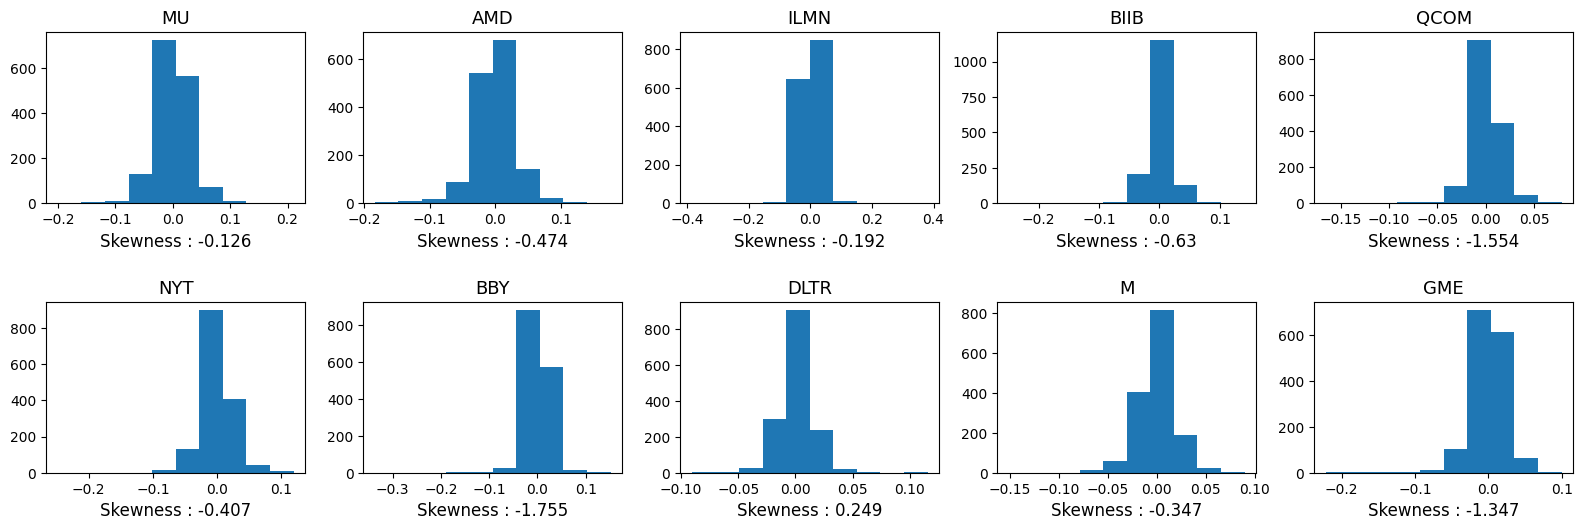

In [ ]:
# View skewness of stock returns
fig, axs = plt.subplots(nrows=math.ceil(len(stocks)/5), ncols=5, figsize=(16,5), constrained_layout=True)
fig.tight_layout(h_pad=5)

for i in range(len(stocks)):
  axs[i//5, i%5].hist(returns[stocks[i]])
  axs[i//5, i%5].set_title(stocks[i], fontsize = 13)
  axs[i//5, i%5].set_xlabel(f'Skewness : {round(stats.skew(returns[stocks[i]][1:], axis=0, bias=True),3)}', fontsize = 12)

<Axes: >

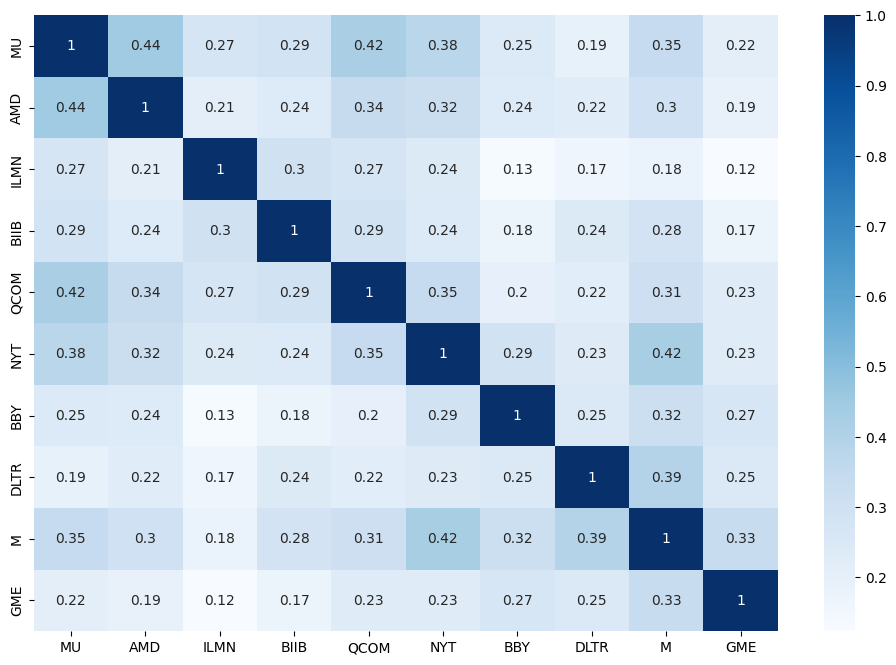

In [ ]:
# View correlation of stock returns
plt.figure(figsize=(12, 8))
sns.heatmap(returns.corr(), cmap="Blues", annot=True)

### Randomised Backtest

In [ ]:
# Backtest on random samples

## Create list to store results
all_results = []

## Calculating number of variations
no_cases = 50
print(no_cases)
print("There are %s variations of parameters to test.\nEach variation will take about 80s to test, so expect a run time of approximately %s minutes" % (no_cases, round(no_cases*4/3,2)))

for counter in range(no_cases):
  ## Monitor number of iterations tested
  if counter % 5 == 0: print('Case %s' % counter)

  bb_ma_window = random.randint(8, 25)
  bb_deviation = random.uniform(0.4, 1.6)
  macd_fast_window = random.randint(12, 24)
  macd_slow_window = random.randint(25, 60)
  macd_signal_window = random.randint(5, 11)
  macd_threshold = random.uniform(-0.5, 0.5)

  A = Group2_Strategy(stocks, benchmark, "2010-01-01", "2015-12-31", "1d", 500000, 0.01, False)
  A.run_strategy(bb_ma_window, bb_deviation, macd_fast_window, macd_slow_window, macd_signal_window, macd_threshold)
  A.performance_backtest()

  ## Store results obtained
  all_results.append({
      'bb_ma_window': bb_ma_window,
      'bb_deviation': bb_deviation,
      'macd_fast_window': macd_fast_window,
      'macd_slow_window': macd_slow_window,
      'macd_signal_window': macd_signal_window,
      'macd_threshold': macd_threshold,
      'performance': A.final_metric
  })

## Create a DataFrame from the list of parameter data sorted by performance metric in descending order
result_df = pd.DataFrame(all_results).dropna().sort_values(by='performance', ascending=False)

## Preview the top 5 sets of parameters based on sharpe ratio
result_df

50
There are 50 variations of parameters to test.
Each variation will take about 80s to test, so expect a run time of approximately 66.67 minutes
Case 0
no more capital


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning:

invalid value encountered in log



Case 5
Case 10
no more capital


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning:

invalid value encountered in log



Case 15
no more capital


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning:

invalid value encountered in log



Case 20
Case 25
Case 30
Case 35
no more capital


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning:

invalid value encountered in log



Case 40
Case 45
no more capital


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning:

invalid value encountered in log



no more capital


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning:

invalid value encountered in log



bb_ma_window  bb_deviation  macd_slow_window  macd_fast_window  \
36            19      1.075466                39                24   
45            18      0.531593                42                17   
16            15      1.517054                27                24   
37            22      0.825415                45                16   
41             9      0.444928                58                24   
42            21      0.416758                39                20   
8             13      1.358413                31                14   
12            13      1.269315                56                23   
33            20      0.478639                28                16   
31            21      0.704894                56                24   
3             14      0.577092                59                19   
34            18      1.236975                58                16   
28             8      0.903606                57                19   
11            25      1.571187                30                15   
13            15      1.289949                56                17   
29             8      1.366670                36                20   
4             19      1.396190                57                14   
39            12      0.401934                59                19   
49             9      0.401202                50                18   
43            18      0.825884                44                16   
46            24      1.207195                51                12   
48            20      0.966770                42                23   
35            14      1.549884                44                19   
38            22      1.244655                54                22   
32            11      0.408527                49                17   
10            13      1.392186                40                14   
17            23      1.267771                57                18   
6             17      1.142824                27                14   
7             11      1.266379                48                12   
47            23      0.967921                52                15   
0             20      1.248650                37                18   
30            15      1.160239                49                15   
9             23      0.867032                29                12   
20            17      1.488309                42                12   
2             13      1.051234                59                15   
22            20      0.888095                40                23   
44             8      1.457428                56                19   
26            13      0.926766                26                22   
14             8      1.362980                27                23   
18            21      1.008127                34                23   
15            11      0.923461                42                24   
19            17      0.546110                25                18   
24            10      0.976159                57                21   
5             24      0.891049                57                23   
27            18      1.016284                58                16   
23            13      1.347270                37                15   
40            21      0.474897                46                15   
21            13      0.813083                46                23   
1             21      0.807240                40                22   
25            20      0.819283                59                12   

    macd_signal_window  macd_threshold  performance  
36                   8       -0.451213     0.577333  
45                   5       -0.386030     0.522804  
16                   9       -0.472771     0.489754  
37                   8       -0.497808     0.342734  
41                   6       -0.353311     0.302610  
42                  10       -0.278388     0.291317  
8                    6       -0.296897     0.291085  
1

### Cache

We cache our results and compiled them together afterwards for analysis

In [ ]:
result_df.to_csv('output1.csv', index=False)

In [ ]:
# Since each backtest variation takes 80s, we ran them separately and compiled the results in "result.csv"
result_df = pd.read_csv('output1.csv').dropna().sort_values(by='performance', ascending=False)
result_df.drop(['Unnamed: 0'], axis = 1, inplace=True)
result_df

bb_ma_window  bb_deviation  macd_slow_window  macd_fast_window  \
0              24      0.828592                35                24   
1              20      0.563242                28                17   
2              12      0.652387                25                18   
3              10      1.581514                27                19   
4              14      0.701425                29                20   
..            ...           ...               ...               ...   
995            18      1.129579                58                20   
996            20      0.714374                57                21   
997            10      0.469137                35                16   
998            12      0.781204                42                13   
999            13      0.440726                54                12   

     macd_signal_window  macd_threshold  performance  
0                     6       -0.440136     0.556743  
1                     7       -0.326053     0.555020  
2                     6       -0.126024     0.529036  
3                     9       -0.458806     0.514277  
4                     8       -0.388331     0.496062  
..                  ...             ...          ...  
995                   5        0.032815    -3.951198  
996                   6        0.044763    -3.998058  
997                   5        0.050775    -4.080694  
998                   5        0.076763    -4.203705  
999                   5        0.076269    -4.235871  

[1000 rows x 7 columns]

### Variations Analysis

With all 1000 variations, we now need to confirm the validity of values chosen in the best variations. We first plot the results of all variations against each of the parameters, highlighting only the top performing variations.

In [ ]:
# Plots graph with top n results and mean result for every discrete value/bin value
def subplot_backtest(result_df, x_col, y_col, n_col, ax, label, highlight_ranges=None, bucket=False):
  reverse_df = result_df.sort_values(by='performance', ascending=True)

  # Plot all results in brown, highlight if in n_col
  sns.scatterplot(x=reverse_df[x_col], y=reverse_df[y_col], c=reverse_df[n_col], ax=ax, cmap=plt.cm.Reds)

  # If variable is continuous, separate into bins to find median
  if bucket:
    # Group into bins and find mean
    _, bins = pd.cut(reverse_df[x_col], 10, retbins=True)
    mids = [(a + b) /2 for a,b in zip(bins[:-1], bins[1:])]
    mean_df = reverse_df.groupby(pd.cut(reverse_df[x_col], 10))[y_col].mean()
    sns.scatterplot(x=mids, y=mean_df.values, ax=ax)
  else:
    # Group by value and find mean
    mean_df = reverse_df.groupby([x_col])[y_col].mean()
    sns.scatterplot(x=mean_df.index, y=mean_df.values, ax=ax)

  # Highlighting the specified ranges
  if highlight_ranges:
    for start, end in highlight_ranges:
        ax.axvspan(start, end, color='green', alpha=0.3)

  # Set labels
  ax.set_xlabel(label)
  ax.set_ylabel('Sharpe Ratio')


def plot_backtest(result_df, n=50, threshold=None, ranges_dict=None):

  # Filter out top n
  top_n = result_df.sort_values('performance', ascending=False).iloc[:n, :] if n is not None else result_df[result_df['performance'] > threshold]

  # Create figure
  _, axes = fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, sharey=True, figsize=(15, 12))
  result_df['is_top_n'] = result_df.index.isin(top_n.index)

  # Create individual subplot for each parameter. If range to be plotted, ranges_dict included
  subplot_backtest(result_df, 'bb_ma_window', 'performance', 'is_top_n', ax1, 'Bollinger Bands MA', ranges_dict.get('bb_ma_window') if ranges_dict else None)
  subplot_backtest(result_df, 'bb_deviation', 'performance', 'is_top_n', ax2, 'Bollinger Bands Deviation', ranges_dict.get('bb_deviation') if ranges_dict else None, True)
  subplot_backtest(result_df, 'macd_slow_window', 'performance', 'is_top_n', ax3, 'MACD Slow Window', ranges_dict.get('macd_slow_window') if ranges_dict else None)
  subplot_backtest(result_df, 'macd_fast_window', 'performance', 'is_top_n', ax4, 'MACD Fast Window', ranges_dict.get('macd_fast_window') if ranges_dict else None)
  subplot_backtest(result_df, 'macd_signal_window', 'performance', 'is_top_n', ax5, 'MACD Signal Window', ranges_dict.get('macd_signal_window') if ranges_dict else None)
  subplot_backtest(result_df, 'macd_threshold', 'performance', 'is_top_n', ax6, 'MACD Threshold', ranges_dict.get('macd_threshold') if ranges_dict else None, True)

  fig.show()

In this case, we highlight the top 3% performing variations in brown and also plot the mean for each discrete/bin value in blue

bb_ma_window  bb_deviation  macd_slow_window  macd_fast_window  \
0              24      0.828592                35                24   
1              20      0.563242                28                17   
2              12      0.652387                25                18   
3              10      1.581514                27                19   
4              14      0.701425                29                20   
..            ...           ...               ...               ...   
995            18      1.129579                58                20   
996            20      0.714374                57                21   
997            10      0.469137                35                16   
998            12      0.781204                42                13   
999            13      0.440726                54                12   

     macd_signal_window  macd_threshold  performance  is_top_n  
0                     6       -0.440136     0.556743      True  
1                     7       -0.326053     0.555020      True  
2                     6       -0.126024     0.529036      True  
3                     9       -0.458806     0.514277      True  
4                     8       -0.388331     0.496062      True  
..                  ...             ...          ...       ...  
995                   5        0.032815    -3.951198     False  
996                   6        0.044763    -3.998058     False  
997                   5        0.050775    -4.080694     False  
998                   5        0.076763    -4.203705     False  
999                   5        0.076269    -4.235871     False  

[1000 rows x 8 columns]

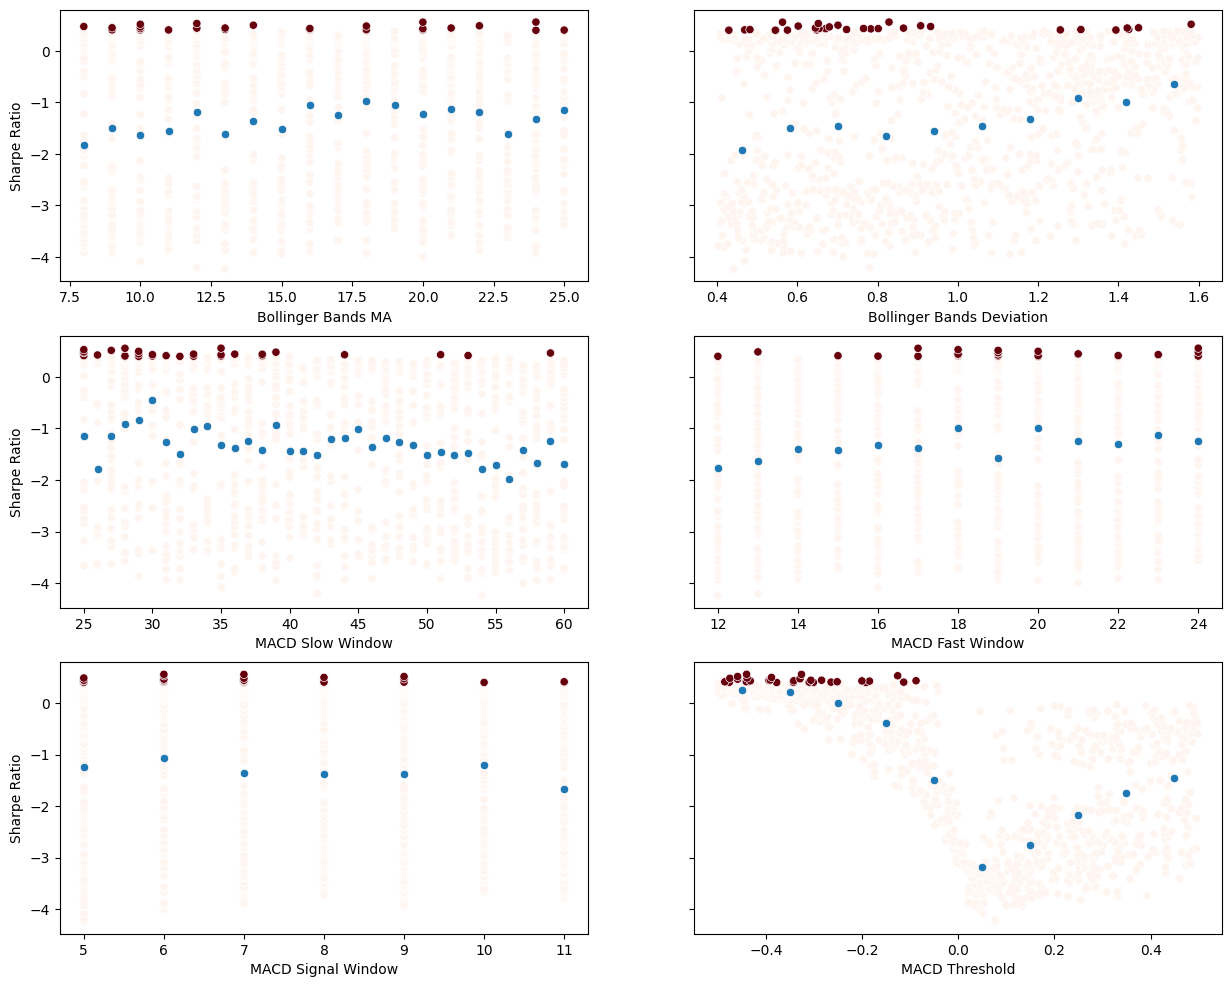

In [ ]:
# Highlight 3% of variations with n = 0.03*no_of_variations
no_of_variations = len(result_df.index)
n = int(0.03 * no_of_variations)

plot_backtest(result_df, n=n, threshold=None)
result_df

Noticeably, most variations had a negative Sharpe Ratio with the included transaction costs. For clearer interpretation, we consider the subset of variations that have positive Sharpe Ratios

270


<ipython-input-6-2834a46c703e>:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



bb_ma_window  bb_deviation  macd_slow_window  macd_fast_window  \
0              24      0.828592                35                24   
1              20      0.563242                28                17   
2              12      0.652387                25                18   
3              10      1.581514                27                19   
4              14      0.701425                29                20   
..            ...           ...               ...               ...   
265            20      1.564073                53                20   
266             8      0.741839                58                24   
267            19      1.306307                25                20   
268            17      0.536518                42                13   
269            12      0.709464                49                20   

     macd_signal_window  macd_threshold  performance  is_top_n  
0                     6       -0.440136     0.556743      True  
1                     7       -0.326053     0.555020      True  
2                     6       -0.126024     0.529036      True  
3                     9       -0.458806     0.514277      True  
4                     8       -0.388331     0.496062      True  
..                  ...             ...          ...       ...  
265                   5       -0.192076     0.027726     False  
266                   8       -0.269119     0.018195     False  
267                   9       -0.067011     0.016647     False  
268                   9       -0.314068     0.013755     False  
269                  10       -0.307118     0.009474     False  

[270 rows x 8 columns]

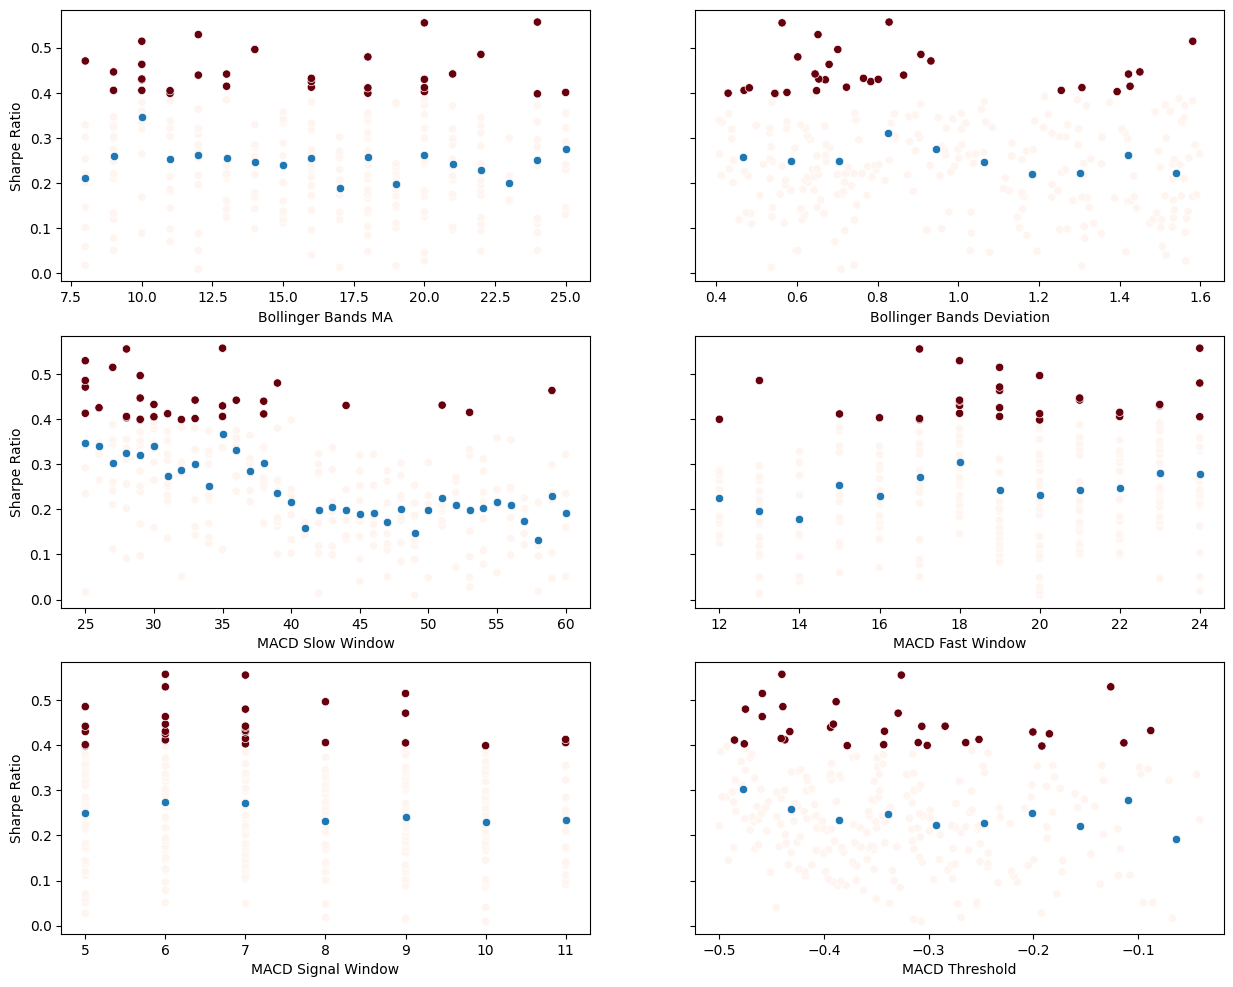

In [ ]:
# Replot graph for subset
sub_df = result_df[result_df['performance']>0]
print(len(sub_df.index))
plot_backtest(sub_df, n=n, threshold=None)
sub_df

### Suitable Parameter Ranges

With the results, we were able to highlight several parameter ranges. This is based on the clustering of top performing results.

In [ ]:
ranges_dict = {
    'bb_ma_window': [(8, 14)],
    'bb_deviation': [(0.5, 1.0)],
    'macd_fast_window': [(18, 24)],
    'macd_slow_window': [(25, 38)],
    'macd_signal_window': [(6, 9)],
    'macd_threshold': [(-0.5, -0.1)]
}

<ipython-input-6-2834a46c703e>:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



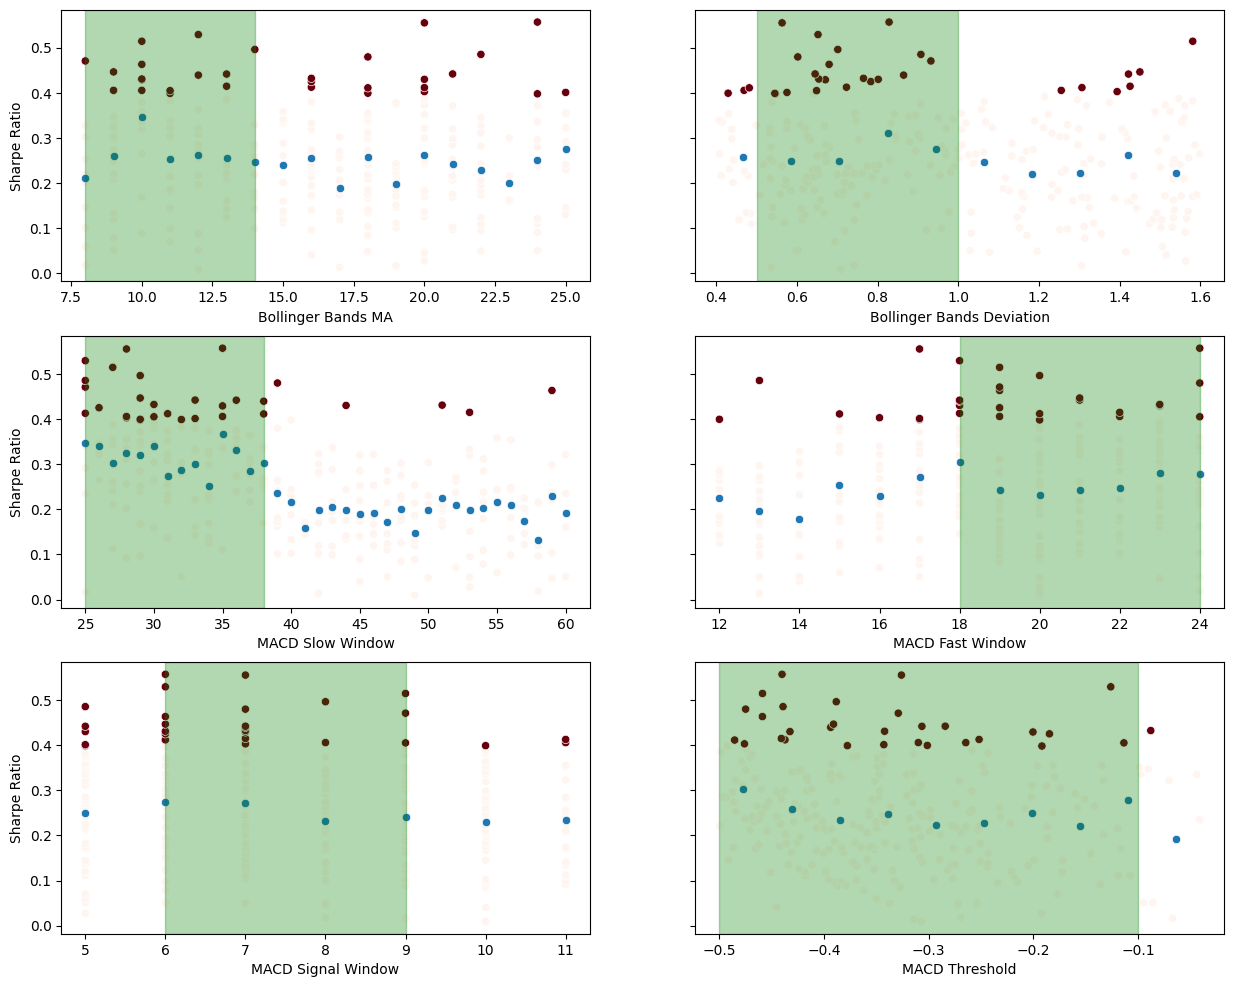

In [ ]:
# Plot with variations with SR>0
plot_backtest(sub_df, n=n, threshold=None, ranges_dict=ranges_dict)

In [ ]:
# We check whether the parameters satisfy the ranges provided
def check_params_in_ranges(df, ranges_dict):

    # Create a new DataFrame to hold the boolean results
    ranges_check_df = pd.DataFrame(index=df.index)

    # Iterate over each parameter and its ranges
    for param, ranges in ranges_dict.items():
        # Apply a function to check if the parameter value falls within any of the ranges
        ranges_check_df[param] = df[param].apply(lambda x: any(lower <= x <= upper for (lower, upper) in ranges))

    return ranges_check_df

# Assuming your DataFrame is named result_df
params_in_ranges_df = check_params_in_ranges(result_df, ranges_dict)
params_in_ranges_df.head()

bb_ma_window  bb_deviation  macd_fast_window  macd_slow_window  \
0         False          True              True              True   
1         False          True             False              True   
2          True          True              True              True   
3          True         False              True              True   
4          True          True              True              True   

   macd_signal_window  macd_threshold  
0                True            True  
1                True            True  
2                True            True  
3                True            True  
4                True            True

From the above analysis, we will be using the third best variation of from our backtester results since it falls within the ranges of parameters that we have
identified
Final Parameters Chosen:


*   bb_ma_window: 12
*   bb_deviation: 0.65
*   macd_slow_window: 25
*   macd_fast_window: 18
*   macd_signal_window: 6
*   macd_threshold: -0.13












## Final Model with Parameters from Backtesting


In [ ]:
# Best variation with full stock list
stocks = ["MU", "AMD", "ILMN", "BIIB", "QCOM", "NYT", "BBY", "DLTR", "M", "GME"]
benchmark = "^GSPC"

A = Group2_Strategy(stocks, benchmark, "2016-01-01", "2019-12-31", "1d", 500000, 0.01, False)
A.run_strategy(12, 0.65, 18, 25, 6, -0.13)
A.performance()
A.performance_plots()

 
Performance Metrics
--------------------------------------------------
<<< Strategy Performance >>>
The total capital at the end of strategy: $1186146.05
The annual regular returns: 24.29 %
The annual regular standard deviation: 19.67 %
The annual sharpe ratio: 1.23
The returns of investment from 2016-01-01 to 2019-12-31 by this strategy is 137.23 %
The maximum drawdown: 20.49 %
The maximum drawdown duration: 473 days
The annual sortino ratio: 1.73
The annual calmar ratio: 1.19
The total trades taken by the strategy 630
--------------------------------------------------
<<< Equal-Weighted Stock Performance >>>
The annual regular returns: 15.71 %
The annual regular standard deviation: 21.44 %
The annual sharpe ratio: 0.73
The returns of investment from 2016-01-01 to 2019-12-31 by an equally-weighted stock strategy is 78.92 %
The maximum drawdown: 30.15 %
The maximum drawdown duration: 465 days
The annual sortino ratio: 1.01
The annual calmar ratio: 0.52
The total trades taken by the s

/usr/local/lib/python3.10/dist-packages/plotly/graph_objs/_deprecations.py:434: DeprecationWarning:

plotly.graph_objs.Marker is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Marker
  - plotly.graph_objs.histogram.selected.Marker
  - etc.




<ipython-input-4-53330e5b18f9>:246: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<ipython-input-4-53330e5b18f9>:246: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<ipython-input-4-53330e5b18f9>:246: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<ipython-input-4-53330e5b18f9>:246: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<ipython-input-4-53330e5b18f9>:246: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<ipython-input-4-53330e5b18f9>:246: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<ipython-input-4-53330e5b18f9>:246: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<ipython-input-4-53330e5b18f9>:246: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<ipython-input-4-53330e5b18f9>:246: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<ipython-input-4-53330e5b18f9>:246: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

